In [19]:
import torch.nn as nn
import torch
import math
import random
from matplotlib import pyplot as plt

In [20]:
random.seed(1001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

1. Dataset

In [3]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-10-29 17:49:09--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2025-10-29 17:49:10 (29.7 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [42]:
# read text file
with open('input.txt', 'r') as file:
  text = file.read()
text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [5]:
len(text)

1115394

In [43]:
# convert text to [ids] according to vocab
vocab = sorted(list(set(text)))
print(vocab)

id_map = {c : i for (i,c) in enumerate(vocab)}
id_map_reverse = {i : c for (i,c) in enumerate(vocab)}
print(id_map)

def encode(text):
  """
    [chars] -> [ids]
  """
  return [id_map[c] for c in text]

def decode(ids):
  """
    [ids] -> string
  """
  return ''.join(id_map_reverse[id] for id in ids)

print(decode(encode("hello")) == "hello")

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
True


In [44]:
# train, val set
train = text[:math.floor(0.9*len(text))]
test = text[math.floor(0.9*len(text)):]

print(f"train size: {len(train)}, test size: {len(test)}")

def fetch_batch(mode, batch_size, block_size):
  if mode=='train':
    dataset = train
  else:
    dataset = test
  batch_indices = [random.randint(0, len(dataset)-(block_size+1)) for _ in range(0, batch_size)]
  x = torch.stack([torch.tensor(encode(dataset[index:index+block_size])) for index in batch_indices])
  y = torch.stack([torch.tensor(encode(dataset[index+1:index+block_size+1])) for index in batch_indices])
  return x,y

train size: 1003854, test size: 111540


In [45]:
class SelfAttentionHead(nn.Module):
  def __init__(self, embed_size, head_size):
    super().__init__()
    self.query = nn.Linear(embed_size, head_size)
    self.key = nn.Linear(embed_size, head_size)
    self.value = nn.Linear(embed_size, head_size)

  def forward(self, x):
    # x : batches, block_size, embed_size [B,T,E]
    q = self.query(x) # : B,T,H
    k = self.key(x)
    v = self.value(x)

    attention_scores = (q @ torch.transpose(k, 1,2)) * (k.shape[-1])**(-0.5) # : B, T, T
    tril = torch.tril(torch.ones((k.shape[1], k.shape[1]))).to(device) # : T, T
    masked_attention_scores = attention_scores.masked_fill(tril == 0, float('-inf')) # : B, T, T

    attention_distribution = torch.softmax(masked_attention_scores, dim=-1)
    weighted_vector = attention_distribution @ v # : B,T,H. @ does batch wise matrix multiplication ie does matrix multiplication for each batch elm
    return weighted_vector

In [46]:
class MultiHeadedAttention(nn.Module):
  def __init__(self, n_heads, embed_size, head_size):
    super().__init__()
    self.multiheaded_sa = nn.ModuleList([SelfAttentionHead(embed_size, head_size) for _ in range(n_heads)])
    self.linear = nn.Linear(embed_size, embed_size)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
    out = [sa(x) for sa in self.multiheaded_sa]
    out = torch.cat(out, dim=-1) # concatenate info from each head
    out = self.linear(out) # interact with each node and do info exchange amongst heads. : B, T, E
    out = self.dropout(out)
    return out

In [47]:
class FeedForwardNetwork(nn.Module):
  def __init__(self, embed_size, hidden_layer_size):
    super().__init__()
    self.layer1 = nn.Linear(embed_size, hidden_layer_size)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(hidden_layer_size, embed_size)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
    out = self.layer1(x)
    out = self.relu(out)
    out = self.layer2(out)
    out = self.dropout(out)
    return out

In [49]:
class Block(nn.Module):
  def __init__(self, embed_size, n_heads, head_size, hidden_layer_size):
    super().__init__()
    self.multi_sa = MultiHeadedAttention(n_heads, embed_size, head_size)
    self.feedforward_net = FeedForwardNetwork(embed_size, hidden_layer_size)
    self.layernorm1 = nn.LayerNorm(embed_size)
    self.layernorm2 = nn.LayerNorm(embed_size)

  def forward(self, x):
    x = x + self.multi_sa(x) # residual conn
    x = self.layernorm1(x)
    x = x + self.feedforward_net(x) # residual conn
    x = self.layernorm2(x)
    return x

In [50]:
class Transformer(nn.Module):
  def __init__(self, vocab_size, embed_size, n_heads, head_size, hidden_layer_size, n_blocks, block_size):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, embed_size)
    self.position_embed = nn.Embedding(block_size, embed_size)
    self.blocks = nn.Sequential(*[Block(embed_size, n_heads, head_size, hidden_layer_size) for _ in range(n_blocks)])
    self.linear = nn.Linear(embed_size, vocab_size)
    self.criterion = nn.CrossEntropyLoss()
    self.block_size = block_size
    self.dropout = nn.Dropout(0.1)

  def forward(self, x, y=None):
    # x : C,T
    embedding = self.embed(x) # : Channels C, Block size T, embedding size E
    position_embedding = self.position_embed(torch.arange(x.shape[1]).to(device)) # : T, E
    x = embedding + position_embedding # makes use of broadcasting over channels for position embedding
    x = self.dropout(x) # dropout for regularization
    out = self.blocks(x)
    logits = self.linear(out)
    if y==None:
      return logits, None

    C,T,E = logits.shape
    logits_temp = logits.view(C*T, E)
    y = y.view(C*T)
    loss = self.criterion(logits_temp, y)
    return logits, loss

  def generate_next_token(self, x):
    logits,_ = self(x)
    # last timestep generated
    logits = logits[:,-1,:] # shape = batches, score over vocab size
    prob = torch.softmax(logits, dim=1)

    # top p sampling
    pred = torch.multinomial(prob, num_samples=1)

    return pred

  def generate(self, x, max_tokens):
    out = x[:,:]
    for _ in range(max_tokens):
      next_word = self.generate_next_token(x)
      x = torch.cat((x, next_word), dim=1) # increase block size
      x = x[:, -self.block_size:] # only retain block size tokens
      out = torch.cat((out, next_word), dim=1)
    return out

In [51]:
transformer = Transformer(65, 128, 4, 32, 256, 2,124)
transformer.to(device)
optimizer = torch.optim.AdamW(transformer.parameters(), lr=3e-4)

In [54]:
# generation without training
x = torch.ones((1,1), dtype=torch.long).to(device)
print(decode(transformer.generate(x,100)[0].tolist()))

 YmWo$,boRFjsntutsVzJ.Dnf$fkDCF3b xK'BE:lWGeL't,TRe!ATZhktCk,-?
$eFIdramlBfdESIggOMeDKKEm?OlbkE,NPdw 


In [55]:
@torch.no_grad()
def performance_measure(batch_size, block_size, n_iters):
  losses = {'train':0, 'val':0}
  transformer.eval()
  for mode in ['train', 'val']:
    for _ in range(n_iters):
      x,y = fetch_batch(mode, batch_size, block_size)
      x = x.to(device)
      y = y.to(device)
      _, loss = transformer(x,y)
      losses[mode] += loss.item()

  transformer.train()
  losses['train'] /= n_iters
  losses['val'] /= n_iters
  return losses

In [56]:
# training loop - added residual conn + layer norm + dropout
n_iters = 10000
iters_eval = 1000
train_loss = []

for iter in range(n_iters):
    x,y = fetch_batch('train', 64, 124)
    x = x.to(device)
    y = y.to(device)

    logits, loss = transformer(x,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

    if iter % iters_eval == 0:
      losses = performance_measure(64, 124, 50)
      print(f"Train loss: {losses['train']}, Val loss: {losses['val']}")

Train loss: 4.229605941772461, Val loss: 4.233317880630493
Train loss: 2.151966919898987, Val loss: 2.182064642906189
Train loss: 1.8752234029769896, Val loss: 1.9646300601959228
Train loss: 1.7429761481285095, Val loss: 1.8878650951385498
Train loss: 1.6664757633209228, Val loss: 1.8356951928138734
Train loss: 1.6198594999313354, Val loss: 1.7983665323257447
Train loss: 1.5845569896697997, Val loss: 1.7696161651611328
Train loss: 1.5540476417541504, Val loss: 1.747708399295807
Train loss: 1.5395204782485963, Val loss: 1.7352668404579163
Train loss: 1.5168310046195983, Val loss: 1.7094068217277527


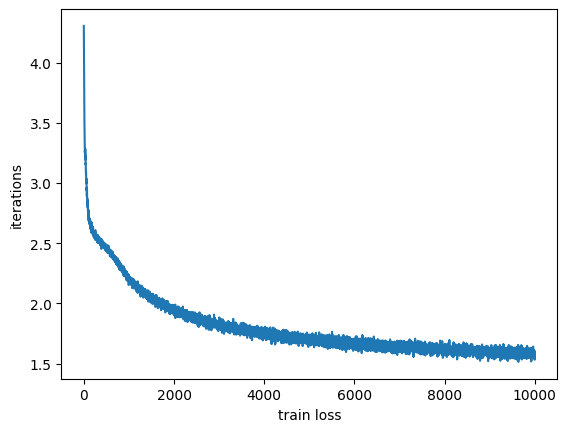

In [57]:
plt.plot(range(n_iters), train_loss)
plt.xlabel('train loss')
plt.ylabel('iterations')
plt.show()

In [58]:
x = torch.ones((1,1), dtype=torch.long).to(device)
print(decode(transformer.generate(x,1000)[0].tolist()))

 may shall coud witrative seak,
I chare your of dischard
The pravottles live, drumbs:
Which serving men! latteen mer our fier rought
The mast the trasces and this with light intood none.
I dother us so quelied with to or betweld's Is!
Look onclooks, hem to-good and better be the wele the mind?

SCMar:
With and marrel speak my spetudge, brather. silve you to-side Edward's
A let vot?
Was imll to hold couse with art stort,
Levise: let too priaish masemblooft brother thade were am ruder's,
Ope in to though, the grace most wife.
And Isabids freelm to am, shall meand,
To from heaven ender for a berought fight less,
And with my limbrone, that with it is voice a bate the have side
To morth, will Tell Mercy strown,
So your of then sing, him timplocks to menument
the knevecall of, and how amouther sit hath lewly but the hume
that Bantwin your so, braa'g, for in shows head
To putterady be it cract for no read perish.
To not bost,-- more and true.

SOMPEY:
Nor Ourse? it any hall appy honour to. Wh